# Predicting the Golden State Warriors(GSW) WIN/LOSS for 2012-2021 period games.


## Introduction

In project 1, I was doing  analytical research on Stephen Curry's influence on Golden State Warriors(GSW) Performance.

In this project I will try to predict whether GSW will win or loss on NBA games betweem 2012 and 2021.


* games.csv : all games from 2004 season to last update with the date, teams and some details like number of points, etc.
* games_details.csv : details of games dataset, all statistics of players for a given game

2 datasets were taken from kaggle.com(https://www.kaggle.com/datasets/nathanlauga/nba-games), while the author used the https://www.nba.com/stats/ to collect these 5 datasets.

* Input Variables:
       'SEASON', - Season Year
       'FG_PCT_gsw', - Field Goal Percentage GSW team
       'FT_PCT_gsw', - Free Throw Percentage of the GSW team
       'FG3_PCT_gsw', - GSW Team three-point field goal percentage(%)
       'AST_gsw', - Assists of the GSW team
       'REB_gsw', - Rebounds of the GSW team
       'FG_PCT_opp', - Field Goal Percentage OPPONENT team
       'FT_PCT_opp', - Free Throw Percentage of the OPPONENT team
       'FG3_PCT_opp', - Opponent Team three-point field goal percentage(%)
       'AST_opp', - Assists of the OPPONENT team
       'REB_opp', - Rebounds of the OPPONENT team
       'Stephen', - Stephen Curry plays this game
       'Klay', - Klay Thompson plays this game
       'Green', - Daymond Green plays this game
       'OPPONENT_XXXXXXXXXX'- OPPONENT TEAM ID as Dummy Variable
       
* Output Varibale:
          'GSW_WIN',- GSW WIN OR LOSS(1, 0) 
      
I believe that 'SEASON' feature will affect the decision making of models in terms of good/bad year for a GSW team. Other features('FG_PCT_gsw', 'FT_PCT_gsw', 'FG3_PCT_gsw', 'AST_gsw','REB_gsw', 'FG_PCT_opp', 'FT_PCT_opp', 'FG3_PCT_opp', 'AST_opp','REB_opp') is a pure statistics of a opposing teams on a given a game, and I think these features will be the maiin feature to relate for making predictions. 'OPPONENT_XXXXXXXXXX' as a dummy variable - GSW can win specific team on regular basis and vice versa. Finally, 'Stephen','Klay', 'Green', these features represents 3 GSW superstar players whether they will play or not.

Output varible was chosen, because the question itself "Will specific team WIN OR LOSS in a given game?" appears in our lives very often, and also predicting this target can then be used in game analytics to propose some counter-strategies agains specific team.

In [214]:
import numpy as np 
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier

In [3]:
games = pd.read_csv('games.csv')
games_det = pd.read_csv('games_details.csv')

In [4]:
gsw_games_12_21 = games[(games['SEASON']>=2012) & (games['SEASON']<2022)]

In [5]:
gsw = gsw_games_12_21[(gsw_games_12_21['HOME_TEAM_ID'] == 1610612744)|(gsw_games_12_21['VISITOR_TEAM_ID'] == 1610612744)]


In [6]:
gsw.drop(['PTS_home', 'PTS_away', 'TEAM_ID_home', 'TEAM_ID_away'], axis = 1, inplace = True)

In [7]:
team_games_h = gsw[(gsw['HOME_TEAM_ID'] == 1610612744)]
team_games_v = gsw[(gsw['VISITOR_TEAM_ID'] == 1610612744)]

team_games_h = team_games_h.rename(columns={'HOME_TEAM_ID': 'GSW',
                                            'VISITOR_TEAM_ID': 'OPPONENT', 
                                            'FG_PCT_home': 'FG_PCT_gsw',
                                            'FT_PCT_home': 'FT_PCT_gsw',
                                            'FG3_PCT_home':'FG3_PCT_gsw',
                                            'AST_home':'AST_gsw',
                                            'REB_home':'REB_gsw',
                                            'FG_PCT_away':'FG_PCT_opp',
                                            'FT_PCT_away':'FT_PCT_opp',
                                            'FG3_PCT_away':'FG3_PCT_opp',
                                            'AST_away':'AST_opp',
                                            'REB_away':'REB_opp'})

team_games_v = team_games_v.rename(columns={'VISITOR_TEAM_ID': 'GSW',
                                            'HOME_TEAM_ID': 'OPPONENT',
                                            'FG_PCT_home': 'FG_PCT_opp',
                                            'FT_PCT_home': 'FT_PCT_opp',
                                            'FG3_PCT_home':'FG3_PCT_opp',
                                            'AST_home':'AST_opp',
                                            'REB_home':'REB_opp',
                                            'FG_PCT_away':'FG_PCT_gsw',
                                            'FT_PCT_away':'FT_PCT_gsw',
                                            'FG3_PCT_away':'FG3_PCT_gsw',
                                            'AST_away':'AST_gsw',
                                            'REB_away':'REB_gsw'})

team_games_v['HOME_TEAM_WINS'] = team_games_v['HOME_TEAM_WINS'].apply(lambda x: 1 if x == 0 else 0)

team_games = pd.concat([team_games_h, team_games_v])

In [8]:
team_games = team_games.rename(columns = {'HOME_TEAM_WINS':'GSW_WIN'})

In [9]:
games_det = games_det.drop_duplicates(subset=["GAME_ID", "PLAYER_NAME"])

In [14]:
def player_presence(name):
    player = games_det[games_det["PLAYER_NAME"] == name]
    player_pres = [1 if i in list(player['GAME_ID'].values) else 0 for i in list(team_games['GAME_ID'].values)]
    return player_pres

In [15]:
team_games['Stephen'] = player_presence('Stephen Curry')
team_games['Klay'] = player_presence('Klay Thompson')
team_games['Green'] = player_presence('Draymond Green')

In [17]:
team_games.drop(['GAME_STATUS_TEXT','GSW','GAME_DATE_EST'], axis = 1, inplace = True)
team_games.set_index('GAME_ID', inplace  = True)

In [91]:
team_games = pd.get_dummies(team_games, columns = ['OPPONENT'])

In [211]:
team_games

,SEASON,FG_PCT_gsw,FT_PCT_gsw,FG3_PCT_gsw,AST_gsw,REB_gsw,FG_PCT_opp,FT_PCT_opp,FG3_PCT_opp,AST_opp,...,OPPONENT_1610612757,OPPONENT_1610612758,OPPONENT_1610612759,OPPONENT_1610612760,OPPONENT_1610612761,OPPONENT_1610612762,OPPONENT_1610612763,OPPONENT_1610612764,OPPONENT_1610612765,OPPONENT_1610612766
GAME_ID,,,,,,,,,,,,,,,,,,,,,
22101008,2021,0.484,0.933,0.400,33.0,55.0,0.413,0.696,0.386,27.0,...,0,0,0,0,0,0,0,0,0,0
22100980,2021,0.478,0.846,0.382,33.0,51.0,0.355,0.826,0.308,23.0,...,0,0,0,0,0,0,0,0,0,0
22100917,2021,0.429,0.600,0.282,27.0,44.0,0.500,0.800,0.382,16.0,...,0,0,0,0,0,0,0,0,0,0
22100883,2021,0.517,0.667,0.294,26.0,37.0,0.473,0.810,0.389,27.0,...,0,0,0,0,0,0,0,0,0,0
22100854,2021,0.444,0.735,0.316,24.0,50.0,0.466,0.667,0.407,25.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11400084,2014,0.418,0.688,0.222,27.0,44.0,0.392,0.606,0.320,19.0,...,0,0,0,0,0,0,0,0,0,0
11400071,2014,0.487,0.852,0.290,26.0,29.0,0.557,0.806,0.632,18.0,...,0,0,0,0,0,0,0,0,0,0
11400042,2014,0.562,0.677,0.394,33.0,44.0,0.366,0.882,0.000,17.0,...,0,0,0,0,0,0,0,0,0,0


In [212]:
team_games.columns

Index(['SEASON', 'FG_PCT_gsw', 'FT_PCT_gsw', 'FG3_PCT_gsw', 'AST_gsw',
       'REB_gsw', 'FG_PCT_opp', 'FT_PCT_opp', 'FG3_PCT_opp', 'AST_opp',
       'REB_opp', 'GSW_WIN', 'Stephen', 'Klay', 'Green', 'OPPONENT_1610612737',
       'OPPONENT_1610612738', 'OPPONENT_1610612739', 'OPPONENT_1610612740',
       'OPPONENT_1610612741', 'OPPONENT_1610612742', 'OPPONENT_1610612743',
       'OPPONENT_1610612745', 'OPPONENT_1610612746', 'OPPONENT_1610612747',
       'OPPONENT_1610612748', 'OPPONENT_1610612749', 'OPPONENT_1610612750',
       'OPPONENT_1610612751', 'OPPONENT_1610612752', 'OPPONENT_1610612753',
       'OPPONENT_1610612754', 'OPPONENT_1610612755', 'OPPONENT_1610612756',
       'OPPONENT_1610612757', 'OPPONENT_1610612758', 'OPPONENT_1610612759',
       'OPPONENT_1610612760', 'OPPONENT_1610612761', 'OPPONENT_1610612762',
       'OPPONENT_1610612763', 'OPPONENT_1610612764', 'OPPONENT_1610612765',
       'OPPONENT_1610612766'],
      dtype='object')

## Experiments

### Data Splitting

In [149]:
X = team_games.drop('GSW_WIN', axis = 1)
y = team_games['GSW_WIN']

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [186]:
y.value_counts(normalize=True) * 100

1    66.528497
0    33.471503
Name: GSW_WIN, dtype: float64

Here, we can see that out target class is unbalanced, so we will use the roc-auc scoring metrics for better reliability.

### Gradient Boosting Classifier


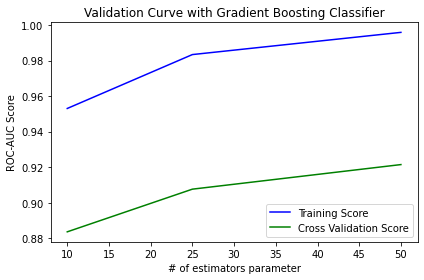

In [191]:
parameter_range =  [10, 25, 50]

train_score, test_score = validation_curve(GradientBoostingClassifier(), X_train, y_train,
                                           param_name = "n_estimators", 
                                           param_range = parameter_range,
                                           cv = 5,
                                           scoring = "roc_auc")

mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')

# Creating the plot
plt.title("Validation Curve with Gradient Boosting Classifier")
plt.xlabel("# of estimators parameter")
plt.ylabel("ROC-AUC Score")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

Here, we can see that both training score and cross validation score show high roc-auc score for the range of number of esitmators. XGBOOST shows too accurate result on training set for 50 estimators, while cross-validation score is relatively low and this can be adressed to an overfitting problem. Reason for this can be, to complex model and small size of dataset.

In [192]:
clf = GradientBoostingClassifier()
parameters = {"learning_rate": [0.01, 0.1, 1, 10],"max_depth":[3, 5, 8],"n_estimators":[10, 25, 50]}

model = GridSearchCV(clf, param_grid=parameters, scoring='roc_auc', cv = 5)
model.fit(X_train, y_train)
    
print('best parameters: ', model.best_params_)
print('best score: ', model.best_score_) 

best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
best score:  0.9217681955594177


ROC-AUC score of XGBOOST classifier on test set: 0.95


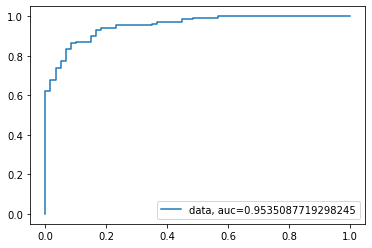

In [194]:
print('ROC-AUC score of XGBOOST classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc_xgb = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc_xgb))
plt.legend(loc=4)
plt.show()

Both results for cross - validaiton and test sets are 0.92 and 0.95, respectively and this shows a great preformance of XGBOOST on predicting our target value.

### Logistic Regression

Logistic regression is not able to learn what value of $C$ to choose. It can not be solve by the optimization problem. Hence, $C$ is the a model hyperparameter that is tuned on GridSearchCV.

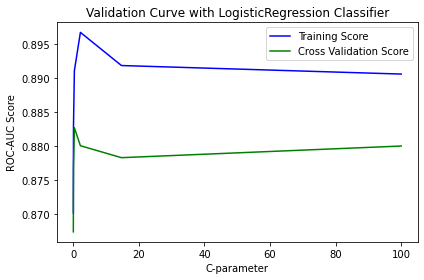

In [195]:
# Setting the range for the parameter (from 1 to 10)
parameter_range = np.logspace(-3,2,7)

train_score, test_score = validation_curve(LogisticRegression(), X_train, y_train,
                                           param_name = "C", 
                                           param_range = parameter_range,
                                           cv = 5,
                                           scoring = "roc_auc")

mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')

# Creating the plot
plt.title("Validation Curve with LogisticRegression Classifier")
plt.xlabel("C-parameter")
plt.ylabel("ROC-AUC Score")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [196]:
parameters={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg, parameters, cv=5,scoring = 'roc_auc')
logreg_cv.fit(X_train,y_train)

print("best parameters: ",logreg_cv.best_params_)
print("best score :",logreg_cv.best_score_)

best parameters:  {'C': 100.0, 'penalty': 'l2'}
best score : 0.879990836956145


$$\large J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

where

- $\mathcal{L}$ is the logistic loss function 
- $C$ is the reverse regularization coefficient 

Here we can say that $C$ corresponds to Complexity of a model.

- if $C$ is small-> regularization is strong-> model will underfit. And on the validation curve graph we can see that indeed at smaller values of C, our model underfitting, because both trends has low accuracy and too close to each other.

- if $C$ is large-> regularization is weak -> model will overfit. However on the validation curve graph we can see that at higher values of C, our model is not overfitting because both trends show relatively good accuracy scores and converge

Logistic Regression has the best roc-auc score(0.88) by setting the hyperparameter $C$ = 100.0 and penalty regularization to l2.

ROC-AUC score of Logistic Regression classifier on test set: 0.89


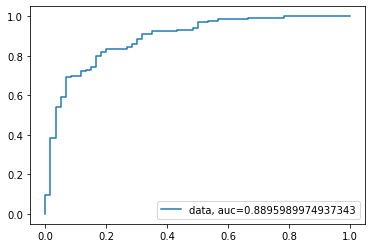

In [197]:
print('ROC-AUC score of Logistic Regression classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, logreg_cv.predict_proba(X_test)[:, 1])))

y_pred_proba = logreg_cv.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc_log = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc_log))
plt.legend(loc=4)
plt.show()

Logistic Regression has almost the same ROC-AUC score on mean cross-validation and test sets $0.88$ and $0.89$, respectively.This shows great generalization preformance of Logistic Regression.

### K-Nearest Neighbors

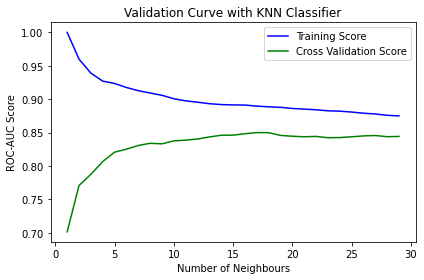

In [198]:
parameter_range = np.arange(1, 30, 1)
train_score, test_score = validation_curve(KNeighborsClassifier(), X_train, y_train,
                                           param_name = "n_neighbors", 
                                           param_range = parameter_range,
                                           cv = 5,
                                           scoring = "roc_auc")

mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')

# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("ROC-AUC Score")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

We can observe here that as the number of neighbours is less than 5, model is simply overfitting, while the tuned hyperparameter starts to increase, the model generalization performance improves.

In [204]:
parameters={"n_neighbors":list(range(1,30)), "p":[1,2]}

knn = KNeighborsClassifier()

model = GridSearchCV(knn, parameters, cv = 5, scoring = 'roc_auc')

knn_model = model.fit(X_train, y_train)

print("best parameters: ",knn_model.best_params_)
print("best score: ",knn_model.best_score_)

best parameters:  {'n_neighbors': 29, 'p': 1}
best score:  0.866507521472714


At the validation graph above, model with n_neighbors = 29 as a tuned hyperparameter have a good fit, where training  and cross-validation curves have good roc-auc scores and close to each other.

ROC-AUC score of KNN classifier on test set: 0.88


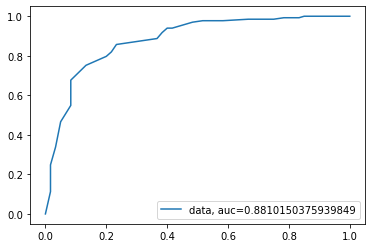

In [203]:
print('ROC-AUC score of KNN classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])))

y_pred_proba = knn_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc_knn = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc_knn))
plt.legend(loc=4)
plt.show()

ROC-AUC score for KNN model on the test and cross-validation sets are almost simillar, 0.87 and 0.88, respectively. We can say that KNN has a good generalization performance on test set.

## Analysis

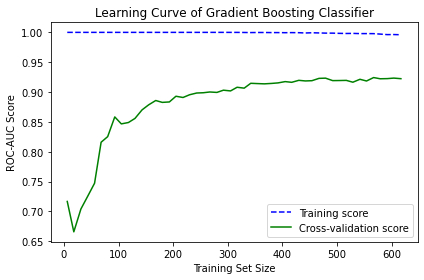

In [208]:
sizes, training_scores, testing_scores = learning_curve(GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 50),
                                                        X_train, y_train, 
                                                        cv=5, 
                                                        scoring='roc_auc', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
  
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
plt.title("Learning Curve of Gradient Boosting Classifier")
plt.xlabel("Training Set Size"), plt.ylabel("ROC-AUC Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

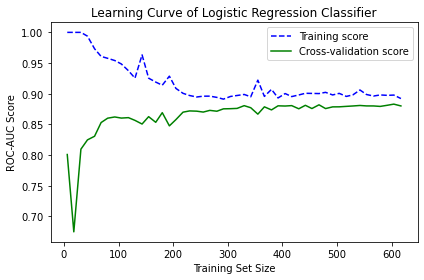

In [207]:
sizes, training_scores, testing_scores = learning_curve(LogisticRegression(C = 100, penalty = 'l2'), X_train, y_train, 
                                                        cv=5, 
                                                        scoring='roc_auc', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
  
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
plt.title("Learning Curve of Logistic Regression Classifier")
plt.xlabel("Training Set Size"), plt.ylabel("ROC-AUC Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

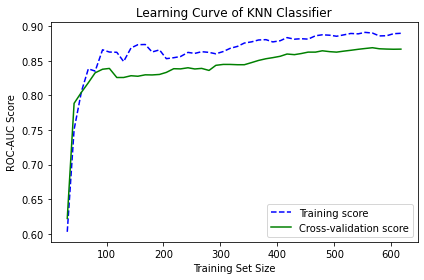

In [206]:
sizes, training_scores, testing_scores = learning_curve(KNeighborsClassifier(n_neighbors = 29, p = 1), X_train, y_train, 
                                                        cv=5, 
                                                        scoring='roc_auc', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
  
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
plt.title("Learning Curve of KNN Classifier")
plt.xlabel("Training Set Size"), plt.ylabel("ROC-AUC Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [205]:
res = {'ROC-AUC scores(test set)': [auc_xgb, auc_log, auc_knn]}
results = pd.DataFrame(res, index = ['Gradient Boosting','Logistic Regression' ,'K-Nearest Neighbors'])
results

,ROC-AUC scores(test set)
Gradient Boosting,0.953509
Logistic Regression,0.889599
K-Nearest Neighbors,0.881015


In all 3 model learning curves, we can observe such pattern where the size of the training set increases, the training score  and the cross-validation score curves start to converge, which is a sign of good generalization performance.Also, as training data, increases, the cross-validation accuracy also increases, so we need to increase our training data.

All three model have relatively good ROC-AUC Scores on data set, however Gradient Boosting have relatively high cross-validation curve scores on learning curve, and high rou-auc score on the test set. So Gradient Boosting classifier is a great model for our task.

In further experiments,we are interested to check our data on linearity and relate this feature to performance of all 3 models.



## Discussion

We examined 3 models such as Gradient Boosting, Logistic Regression and K Nearest Neighbors on predictig the GSW WIN/LOSS as our target value. We have used GridSearchCV for hyperparameter tuning to see which set of parameters will give the most reliable results.Also Validation curves and Learning curves were plotted for each model, to show whether model overfits/underfits relating to hyperparameters and size of training set.Evaluation was done by ROC-AUC metric, as it is more reliable in terms of unbalanced data.

If this research project will be continued, we'd like to research linearity/non-linearity of data, and also collinearity, as it might be reason of model relatively good/poor performance.

Furthermore, I also wanted to analyze how each feature is contributed to a model performance.

## Conclusion

Doing this research project,I have learned to transform data features to numerical for model fitting, and also to analyze each model in terms of generalization by plotting validation and learning curves.Also, I realized, how setting parameters of a model can greatly increase performance of a model.

The main disadvantage of this project is that some dataset features are only known after the game will proceed. So these models would not benefit gamblers to make their bets on NBA games.